# Laborator 6 - Segmentare Semantica

In acest laborator veti implementa si antrena o retea complet convolutionala ([DeepLabV3](https://arxiv.org/pdf/1706.05587.pdf)), al carei rezultat este o imagine (nu doar clasificare). Veti implementa varianta originala, cat si o adaptare bazata pe MoE (Mixture of Experts) si antrenarea retelei pentru a clasifica fiecare pixel din imagine.

Veti construi o retea de segmentare semantica pentru a identifica spatiul liber pe drum (veti folosi setul de date [Kitti Road](http://www.cvlibs.net/datasets/kitti/eval_road.php)).

## De ce DeepLabV3?

DeepLabV3 este o arhitectură de segmentare semantică avansată care îmbunătățește performanța și precizia în comparație cu alte modele, cum ar fi FCN. Acest lucru se datorează mai multor caracteristici unice ale DeepLabV3.

În primul rând, DeepLabV3 utilizează o arhitectură encoder-decoder, similară cu FCN, care păstrează informațiile spațiale pe tot parcursul rețelei, permițându-i să funcționeze cu imagini de orice dimensiune. Aceasta este o caracteristică esențială pentru segmentarea semantică, deoarece permite modelului să înțeleagă contextul spațial al obiectelor din imagine.

În al doilea rând, DeepLabV3 introduce un modul de atrous spatial pyramid pooling (ASPP) la finalul encoderului. ASPP permite modelului să captureze informații la diferite scale și să gestioneze mai bine obiectele de diferite dimensiuni. Acest lucru este deosebit de util pentru segmentarea semantică, deoarece obiectele dintr-o imagine pot varia semnificativ în dimensiune.

În al treilea rând, DeepLabV3 utilizează convoluții atrous (dilate) pentru a mări câmpul de vedere al rețelei fără a crește numărul de parametri sau a calcula costul. Aceasta permite modelului să capteze mai mult context fără a sacrifica eficiența.

Aceste caracteristici fac DeepLabV3 un model puternic pentru segmentarea semantică. În plus, DeepLabV3 gestionează eficient tensiunea între semantică și locație: informațiile globale rezolvă problema clasei - “CE”, în timp ce convoluțiile atrous și ASPP permit modelului să captureze mai bine informațiile locale - “UNDE”.


![atrous](https://miro.medium.com/v2/resize:fit:640/format:webp/1*-r7CL0AkeO72MIDpjRxfog.png)

![deep](https://miro.medium.com/v2/resize:fit:2000/format:webp/1*nFJ_GqK1D3zKCRgtnRfrcw.png)

In [1]:
# Create directories (if they don't already exist)
!mkdir -p /kaggle/working/data /kaggle/working/runs /kaggle/working/saved_models

# Download the dataset using wget
!wget --progress=bar:force https://s3.eu-central-1.amazonaws.com/avg-kitti/data_road.zip -P /kaggle/working/data

# Unzip the dataset
!unzip -q /kaggle/working/data/data_road.zip -d /kaggle/working/data

--2025-04-05 14:17:02--  https://s3.eu-central-1.amazonaws.com/avg-kitti/data_road.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.72.88, 52.219.169.185, 52.219.169.161, ...
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.72.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 470992343 (449M) [application/zip]
Saving to: ‘/kaggle/working/data/data_road.zip’

data_road.zip       100%[===================>] 449.17M  22.3MB/s    in 22s     

2025-04-05 14:17:25 (20.8 MB/s) - ‘/kaggle/working/data/data_road.zip’ saved [470992343/470992343]



# Pregatirea setului de date

In celula de mai jos sunt implementate clasele torch.utils.data.Dataset ce vor fi folosite pentru a itera prin seturile de date de antrenare si de test din Kitti Road Segmentation.

De asemenea sunt implementate doua *collate_fn()* una pentru antrenare ce returneaza si imagini si adnotari, si una pentru testare ce returneaza doar imagini.

In final sunt instantiate 3 obiecte torch.utils.data.DataLoader: unul pentru antrenare, unul pentru testare si unul pentru vizualizare.

## Cerinta
Augumentati datele de antrenare, cu tehnici precum random flip si ajustari de luminozitate, contrast, hue etc. [2p]

Hints:
* asigurati-va ca augumentarile au sens.
* asigurati-va ca label-urile raman corecte.
* asigurati-va ca operatia pe care o faceti nu modifica permanent imaginea originala.
* toate ajustarile trebuie sa difere de la o epoca la alta,a stfel parametri trebui generati random din diverse distributii (uniforma, gaussiana)

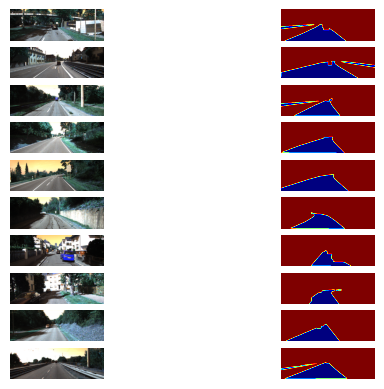

In [2]:
import os
import glob
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.v2 as transforms

from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import normalize, to_tensor
from sklearn.model_selection import train_test_split


%matplotlib inline

TRAIN_IMAGES_PATH = "/kaggle/working/data/data_road/training/image_2"
TRAIN_LABELS_PATH = "/kaggle/working/data/data_road/training/gt_image_2"
TEST_IMAGES_PATH = "/kaggle/working/data/data_road/testing/image_2"

def collate_fn_train(examples):
  images = []
  labels = []
  for example in examples:
    image, label = example
    image = to_tensor(image)
    image = normalize(image, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    image = image.unsqueeze(0)
    label = torch.tensor(label).unsqueeze(0)
    images.append(image)
    labels.append(label)

  images_batch = torch.cat(images)
  labels_batch = torch.cat(labels)

  return images_batch, labels_batch

def collate_fn_test(examples):
  images = []
  for example in examples:
    image = example
    image = to_tensor(image)
    image = normalize(image, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    image = image.unsqueeze(0)
    images.append(image)

  images_batch = torch.cat(images)

  return images_batch

class KittiImageDataset(Dataset):
  def __init__(self, images_root, original_shape=(1242, 375) ,
               load_shape=(384, 128)):
    self.images_root = images_root
    self.original_shape = original_shape
    self.load_shape = load_shape

    self.images = []
    image_paths = sorted(glob.glob(os.path.join(images_root, '*')))
    for path in image_paths:
        image = cv2.imread(path)
        image = cv2.resize(image, self.load_shape)
        self.images.append(image)

  def __getitem__(self, idx):
    image = self.images[idx]
    return image

  def __len__(self):
    return len(self.images)

class KittiTrainDataset(KittiImageDataset):
    def __init__(self, images_root, labels_root, original_shape=(1242, 375), load_shape=(384, 128)):
        super().__init__(images_root, original_shape, load_shape)
        self.labels = []
        label_paths = sorted(glob.glob(os.path.join(labels_root, '*_road_*')))
        self.transform = transforms.Compose([
            transforms.ColorJitter(brightness=np.random.uniform(0, 0.2), contrast=np.random.uniform(0, 0.2), hue=np.random.uniform(0, 0.1))
        ])
        self.transform_flip = transforms.RandomHorizontalFlip(p=np.random.uniform())
        
        for path in label_paths:
            label = cv2.imread(path)
            label = cv2.resize(label, self.load_shape, interpolation=cv2.INTER_NEAREST)

            new_label = label.sum(axis=2)
            new_label = np.where(new_label == 255, 1, 0)
            self.labels.append(new_label)
            
    def __getitem__(self, idx):
        image = super().__getitem__(idx)
        label = self.labels[idx]
        
        image = self.transform(image)
        image, label = self.transform_flip(image, label)
        
        return image, label

labeled_dataset = KittiTrainDataset(TRAIN_IMAGES_PATH, TRAIN_LABELS_PATH)
test_dataset = KittiImageDataset(TEST_IMAGES_PATH)

# Split the labeled_dataset into train and validation sets
train_dataset, val_dataset = train_test_split(labeled_dataset, test_size=0.1, random_state=42)

# Create data loaders for train and validation sets
vis_dataloader = DataLoader(labeled_dataset, shuffle=True)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, collate_fn=collate_fn_train)
val_dataloader = DataLoader(val_dataset, shuffle=False, num_workers=2, collate_fn=collate_fn_train)
test_dataloader = DataLoader(test_dataset, shuffle=False, collate_fn=collate_fn_test)


num_samples = 10
vis_iter = iter(vis_dataloader)
for i in range(num_samples):
    image, label = next(vis_iter)
    image = image.squeeze(0).numpy()
    label = label.squeeze(0).numpy()
    
    plt.subplot(num_samples, 2, 2*i+1)
    plt.axis('off')
    plt.imshow(image, None)
    plt.subplot(num_samples, 2, 2*i+2)
    plt.axis('off')
    plt.imshow(label[:, :], 'jet')

# Implementarea Retelei DeepLab


In celula urmatoare se gaseste codul partial pentru implementarea retelei DeepLab.

Arhitectura contine:
 * un encoder, bazat pe ResNet 50 sau ResNet 101.
 * un decoder, bazat pe module ASPP

 Mai mult, aceasta arhitectura o vom adapta la ideea de MoE (Mixture of Experts).

  ![deeplab](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*5uWAA4VEkFane36gUTHdYg.png)


 Astfel arhitectura se va modifica:
 * acelasi encoder
 * o retea (chiar si cu un singur strat de neuroni) care sa ne dea probabilitatile de a folosi un anume expert.
 * n decodere, n fiind numarul de experti.


 Pipelineul acestei retele este urmatorul:
 * imaginea trece prin encoder
 * imaginea encodata trece prin reteaua de gating, si se optiun cele n probabilitati
 * imaginea encodata trece prin *fiecare* din cele n decodere si se obtin n imagini
 * cele n imagini decodate sunt combinate, folosind o medie ponderata, unde ponderile sunt date de reteaua de gating

 Astfel, intreaga retea decide ce decoder este mai potrivit pentru un anumit scenariu, in functie de inputul dat.

  ![gating](https://deepgram.com/_next/image?url=https%3A%2F%2Fwww.datocms-assets.com%2F96965%2F1695407447-image1.png&w=1920&q=75)

## Ceinta

 a) Implementati arhitectura retelei DeepLab [2p].

 b) Adapatati arhitectura folosind ideea de MoE [3p].

 c) Implementati un modul ASPP, asa cum este prezentat in diagrama, la rubrica (a). Nu este nevoie sa implementati si partea de image pooling. [bonus: 1p]


 **Hint:**
  * pentru arhitectura DeepLab puteti sa va folositi de module din torchvision.models.segmentation






In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels=256, atrous_rates=[6, 12, 18]):
        super(ASPP, self).__init__()

        self.paths = []

        self.paths.append(
            nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel=1, stride=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU()
            )
        )

        for rate in atrous_rate:
            self.paths.append(
                nn.Sequential(
                    nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel=3, stride=1, padding=rate, dilation=rate),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU()
                )
            )

        self.conv = nn.Conv2d(in_channels=out_channels * len(self.paths), out_channels=out_channels, kernel=1, stride=1)

    def forward(self, x):
        x = torch.cat(*self.paths, 1)
        x = self.conv(x)

        return x

In [4]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

class GatedDeepLab(nn.Module):
    def __init__(self, num_classes, num_experts=4):
        super(GatedDeepLab, self).__init__()
        # Codul vostru aici
        self.encoder = models.segmentation.deeplabv3_resnet50(num_classes=num_classes)
        
        self.decoders = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(2048, 32, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv2d(32, num_classes, kernel_size=1)
            )
            for _ in range(num_experts)])
        
        self.gating = nn.Sequential(
            nn.Conv2d(in_channels=2048, out_channels=32, kernel_size=1, stride=1),
            nn.AdaptiveAvgPool2d((1,1)), # Shape: (batch_size, 32, 1, 1)
            nn.Conv2d(in_channels=32, out_channels=num_experts, kernel_size=1, stride=1), # Shape: (batch_size, num_experts, 1, 1)
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.encoder.backbone(x)["out"]
        
        gate_weights = self.gating(x).squeeze(-1).squeeze(-1) # Shape: (batch_size, num_experts)

        output_decoders = []
        for index, decoder in enumerate(self.decoders):
            output = decoder(x) * gate_weights[:, index].unsqueeze(1).unsqueeze(2).unsqueeze(3) # Shape: (batch_size, 1, 1, 1) to match (batch_size, 2, 16, 48)
            output_decoders.append(output)

        output = torch.stack(output_decoders, dim=0).sum(dim=0)
        bilinear_upsample = nn.Upsample(size=(128, 384), mode="bilinear", align_corners=False)

        return bilinear_upsample(output)

## Cerinta
a) Creati o retea de tip U-net cu acelasi scop de segmentare semantica. Reteaua trebuie scris de la zero, neputand importa module intregi din diverse librarii. [bonus: 1p]

b) Antrenati reteaua U-net pe acelasi task. [bonus: 1p]

  ![unet](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [27]:
class DoubleConv2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv2d, self).__init__()

        self.double_conv2d = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        

    def forward(self, x):
        return self.double_conv2d(x)

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        self.encoder = nn.ModuleList([
            DoubleConv2d(in_channels, 64),
            DoubleConv2d(64, 128),
            DoubleConv2d(128, 256),
            DoubleConv2d(256, 512),
            DoubleConv2d(512, 1024),
        ])

        self.decoder = nn.ModuleList([
            DoubleConv2d(1024, 512),
            DoubleConv2d(512, 256),
            DoubleConv2d(256, 128),
            DoubleConv2d(128, 64),
        ])

        self.deconv = nn.ModuleList([
            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2),
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
        ])

        self.pool = nn.MaxPool2d((2,2))
        self.last_layer_conv = nn.Conv2d(in_channels=64, out_channels=out_channels, kernel_size=1, stride=1)

    def forward(self, x):
        stk = []
        for encoder in self.encoder:
            x = encoder(x)
            stk.append(x)
            x = self.pool(x)

        x = stk.pop(-1)
        for index in range(len(self.decoder)):
            encoder_output = stk.pop(-1)
            x = self.deconv[index](x)
            x = torch.cat([encoder_output, x], dim=1)
            x = self.decoder[index](x)

        return self.last_layer_conv(x)

# Antrenarea retelei

## Cerinta
Setati parametri lipsa si faceti cel putin doua antrenari (cu parametri diferiti) folosind DeepLab si versiunea sa gated [2p]

In colab, pentru a folosi GPU-ul trebuie sa mutati sesiune pe T4.
In rubrica de "runtime" -> "change runtime type" -> "T4 GPU". Nu uitati sa deconectati sesiunea dupa ce ati terminat.

In [15]:
# Codul vostru aici

import torch.optim as optim
import matplotlib.pyplot as plt

def train_fn(model, num_epochs, lr):
    # Initialize the loss function
    loss_fn = nn.CrossEntropyLoss()
    
    # Initialize the optimizer
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    optimizer.zero_grad()
    
    # Lists to store the training and validation losses
    train_losses = []
    val_losses = []
    
    # Train the network
    for epoch in range(num_epochs):
    
      train_loss = 0.0
      val_loss = 0.0
    
      # Training
      model.train()
      for idx, (image, label) in enumerate(train_dataloader):
        pred = model(image.cuda())
        loss = loss_fn(pred, label.cuda())
    
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
        train_loss += loss.item()
    
        if idx % 10 == 0:
          print("Epoch {} - Iter {} - Loss {}".format(epoch, idx, loss.item()))
    
      # Validation
      model.eval()
      with torch.no_grad():
        for idx, (image, label) in enumerate(val_dataloader):
          pred = model(image.cuda())
          loss = loss_fn(pred, label.cuda())
          val_loss += loss.item()
    
      # Calculate average losses
      train_loss /= len(train_dataloader)
      val_loss /= len(val_dataloader)
    
      # Append losses to the lists
      train_losses.append(train_loss)
      val_losses.append(val_loss)
    
      print("Epoch {} - Training Loss: {:.4f} - Validation Loss: {:.4f}".format(epoch, train_loss, val_loss))
    
    # Plot the training and validation losses
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# DeepLabV3 Train

Epoch 0 - Iter 0 - Loss 0.7123715877532959
Epoch 0 - Iter 10 - Loss 0.21713216602802277
Epoch 0 - Training Loss: 0.2861 - Validation Loss: 0.1957
Epoch 1 - Iter 0 - Loss 0.1918734759092331
Epoch 1 - Iter 10 - Loss 0.14206138253211975
Epoch 1 - Training Loss: 0.1348 - Validation Loss: 0.1041
Epoch 2 - Iter 0 - Loss 0.11375866085290909
Epoch 2 - Iter 10 - Loss 0.08152549713850021
Epoch 2 - Training Loss: 0.0904 - Validation Loss: 0.0999
Epoch 3 - Iter 0 - Loss 0.07932207733392715
Epoch 3 - Iter 10 - Loss 0.09855107218027115
Epoch 3 - Training Loss: 0.0733 - Validation Loss: 0.0848
Epoch 4 - Iter 0 - Loss 0.06107247993350029
Epoch 4 - Iter 10 - Loss 0.0617733858525753
Epoch 4 - Training Loss: 0.0580 - Validation Loss: 0.0766
Epoch 5 - Iter 0 - Loss 0.04951082170009613
Epoch 5 - Iter 10 - Loss 0.044811397790908813
Epoch 5 - Training Loss: 0.0531 - Validation Loss: 0.0873
Epoch 6 - Iter 0 - Loss 0.045629847794771194
Epoch 6 - Iter 10 - Loss 0.06855715066194534
Epoch 6 - Training Loss: 0.051

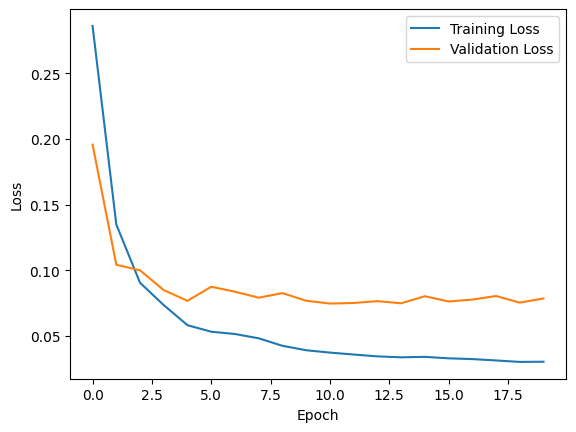

In [19]:
num_experts = 4
num_epochs = 20
lr = 1e-4
model_deeplab_v3 = GatedDeepLab(2, num_experts).cuda()

train_fn(model_deeplab_v3, num_epochs, lr)

# UNet Train

Epoch 0 - Iter 0 - Loss 0.6171908378601074
Epoch 0 - Iter 10 - Loss 0.3819573223590851
Epoch 0 - Training Loss: 0.4246 - Validation Loss: 0.6380
Epoch 1 - Iter 0 - Loss 0.3091854751110077
Epoch 1 - Iter 10 - Loss 0.28593459725379944
Epoch 1 - Training Loss: 0.2683 - Validation Loss: 0.3258
Epoch 2 - Iter 0 - Loss 0.22136348485946655
Epoch 2 - Iter 10 - Loss 0.21298062801361084
Epoch 2 - Training Loss: 0.2140 - Validation Loss: 0.2208
Epoch 3 - Iter 0 - Loss 0.2070886492729187
Epoch 3 - Iter 10 - Loss 0.18425112962722778
Epoch 3 - Training Loss: 0.1894 - Validation Loss: 0.1911
Epoch 4 - Iter 0 - Loss 0.16415563225746155
Epoch 4 - Iter 10 - Loss 0.17517893016338348
Epoch 4 - Training Loss: 0.1746 - Validation Loss: 0.1690
Epoch 5 - Iter 0 - Loss 0.17011035978794098
Epoch 5 - Iter 10 - Loss 0.15200866758823395
Epoch 5 - Training Loss: 0.1577 - Validation Loss: 0.1654
Epoch 6 - Iter 0 - Loss 0.1531492918729782
Epoch 6 - Iter 10 - Loss 0.15181852877140045
Epoch 6 - Training Loss: 0.1576 - 

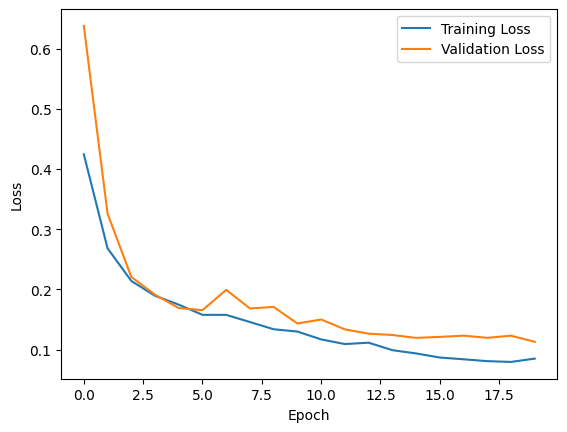

In [35]:
# remove memory cache from previous train
import gc
gc.collect()
torch.cuda.empty_cache()

model_unet = UNet(3, 2).cuda()
num_epochs = 20
lr = 1e-4

train_fn(model_unet, num_epochs, lr)

# Rularea retelei pe setul de date de test si vizualizare

## Cerinta
 Procesati iesirea retelei pentru a vizualiza masca de segmentare prezisa ca in celula pentru pregatirea setului de date. [1p]

**Hints**
 * Iesirea va fi un feature map de dimensiunea imaginii de intrare cu 2 canale.
 * Pentru fiecare pixel canalele trebuiesc transformate intr-o distributie de probabilitati (Softmax)
 * Transformati intr-o imagine cu un singur canal cu valori 255 pentru clasa 'road' si 0 pentru clasa 'background'

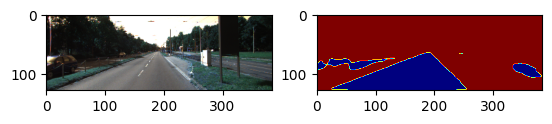

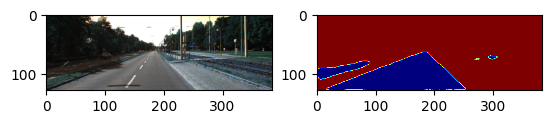

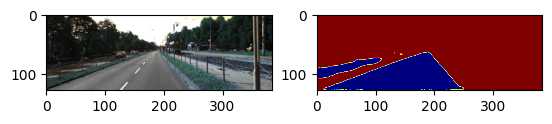

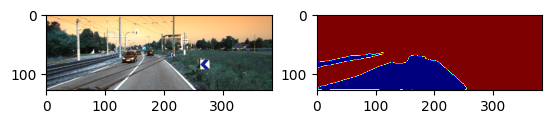

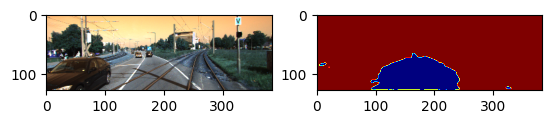

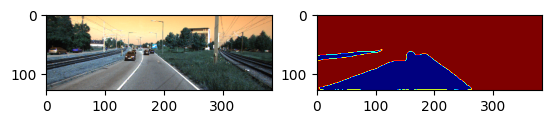

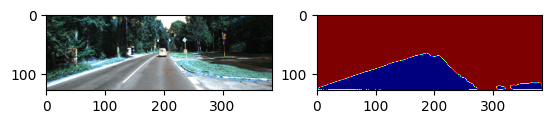

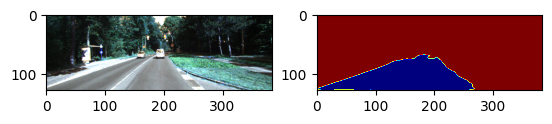

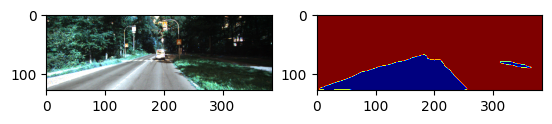

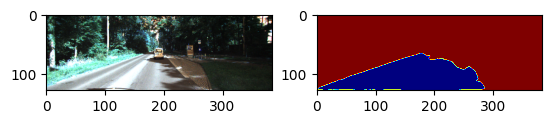

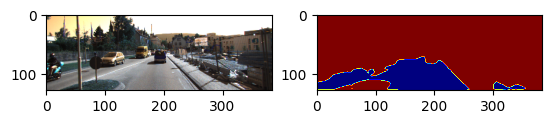

In [42]:
model = model_unet
model.eval()

num_to_show = 10

softmax = nn.Softmax(dim=1)
# Ne asiguram ca nu se pot propaga gradienti prin retea
with torch.no_grad():
  for idx, image in enumerate(test_dataloader):

    if idx > num_to_show:
      break

    logits = model(image.cuda())

    # Postprocesarea imaginii pentru a fi vizualizata
    image = (image.squeeze(0).clone().cpu().numpy().transpose(1, 2, 0) + 1) / 2.0

    #### Codul vostru aici - postprocesarea iesirii retelei pentru a
    #### fi vizualizata
    pred = nn.Softmax(dim=1)(logits)
    pred = np.transpose(pred.squeeze(0).clone().cpu().numpy(), (1, 2, 0))
    pred = np.argmax(pred, axis=-1)

    # Cod de vizualizare
    fig = plt.figure()
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(image)
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(pred, cmap="jet")